In [1]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from google.colab import drive

In [2]:
class image_data_set(torch.utils.data.Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return {'data': self.data[index], 'label': self.labels[index]}

In [3]:
def get_image_tensor(file_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    image = Image.open(file_path)
    return transform(image)

def get_data_and_labels(directory_path, label):
    image_tensors, labels = [], []
    for file in os.listdir(directory_path):
        if file.endswith(".JPG"):
            file_path = directory_path + file
            image_tensor = get_image_tensor(file_path)
            image_tensors.append(image_tensor)
            labels.append(label)
            
    return image_tensors, labels

def get_data_for_label(file_pathes, label): 

  all_data, all_labels = [], []
  for file_path in file_pathes:
      data, labels = get_data_and_labels(file_path, label)
      all_data.extend(data)
      all_labels.extend(labels)

  return all_data, all_labels
    
def get_data_sets(present_file_pathes, not_present_file_pathes): 

    present_data, present_labels = get_data_for_label(present_file_pathes, 1)
    not_present_data, not_present_labels = get_data_for_label(not_present_file_pathes, 0)
    
    print("Number of wildlife present photos: " + str(len(present_data)))
    print("Number of no wildlife present photos: " + str(len(not_present_data)))
    
    data = present_data + not_present_data
    labels = present_labels + not_present_labels
    
    training_data, testing_data, training_labels, testing_labels = train_test_split(data, labels)
    
    print("\nNumber of training photos: " + str(len(training_data)))
    print("Number of testing photos: " + str(len(testing_data)))
    
    training_data_set = image_data_set(training_data, training_labels)
    testing_data_set = image_data_set(testing_data, testing_labels)
    
    return training_data_set, testing_data_set

def get_loaders(training_data_set, testing_data_set, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data_set,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data_set,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader

In [15]:
def print_testing_analysis(all_labels, all_predictions):
    subplot = plt.subplot()

    cf_matrix = confusion_matrix(all_labels, all_predictions, labels=[1, 0])
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

    subplot.set_xlabel('Predictions')
    subplot.set_ylabel('Labels')
    subplot.set_title('Confusion Matrix')
    subplot.xaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    subplot.yaxis.set_ticklabels(['Wildlife Present', 'No Wildlife Present'])
    plt.show()

    accuracy = accuracy_score(all_labels, all_predictions)
    print("Accuracy: " + str(accuracy))

    precision, recall, f_score, support = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    print("Precision: " + str(precision))
    print("Recall: " + str(recall))
    print("F-Score: " + str(f_score))

def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(training_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/len(training_loader.dataset)
    return loss, accuracy

def test(model, testing_loader, criterion):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    all_labels, all_predictions = [], []

    for i, data in enumerate(testing_loader):
        data, labels = data['data'].to(device), data['label'].to(device)
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        all_labels.extend(labels.cpu())
        all_predictions.extend(predictions.cpu())
    
    loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/len(testing_loader.dataset)
    return loss, accuracy, all_labels, all_predictions

In [12]:
def train_and_test(model, training_loader, testing_loader, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    labels, predictions = [], []
    
    for epoch in range(5):
        print("epoch: " + str(epoch))
        
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        print("training loss: " + str(training_loss) + " and training accuracy: " + str(training_accuracy))
        
        testing_loss, testing_accuracy, labels, predictions = test(model, testing_loader, criterion)
        print("testing loss: " + str(testing_loss) + " and testing accuracy: " + str(testing_accuracy))

    print_testing_analysis(labels, predictions)

In [22]:
def train_and_test_VGG11(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing VGG11")
    vgg11 = models.vgg11(weights = models.VGG11_Weights.DEFAULT)
    vgg11.classifier[6].out_features = num_classes
    train_and_test(vgg11, training_loader, testing_loader, device)

def train_and_test_VGG19(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing VGG19")
    vgg19 = models.vgg19(weights = models.VGG19_Weights.DEFAULT)
    vgg19.classifier[6].out_features = num_classes
    train_and_test(vgg19, training_loader, testing_loader, device)

def train_and_test_ResNet50(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet50")
    resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
    resnet50.fc.out_features = num_classes
    train_and_test(resnet50, training_loader, testing_loader, device)

def train_and_test_ResNet152(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing ResNet152")
    resnet152 = models.resnet152(weights = models.ResNet152_Weights.DEFAULT)
    resnet152.fc.out_features = num_classes
    train_and_test(resnet152, training_loader, testing_loader, device)
    
def train_and_test_AlexNet(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing AlexNet")
    alexnet = models.alexnet(weights = models.AlexNet_Weights.DEFAULT)
    alexnet.classifier[6].out_features = num_classes
    train_and_test(alexnet, training_loader, testing_loader, device)

def train_and_test_SSD(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing SSD")
    ssd300_vgg16 = models.detection.ssd300_vgg16(weights = models.detection.SSD300_VGG16_Weights.COCO_V1)
    train_and_test(ssd300_vgg16, training_loader, testing_loader, device)
    
def train_and_test_Faster_RCNN(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing Faster R-CNN")
    faster_rcnn = models.detection.fasterrcnn_resnet50_fpn_v2(weights = models.detection.FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
    faster_rcnn.roi_heads.box_predictor.bbox_pred.out_features = num_classes
    train_and_test(faster_rcnn, training_loader, testing_loader, device)
    
def train_and_test_YOLO(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing YOLO")
    yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    train_and_test(yolo, training_loader, testing_loader, device)

def train_and_test_ViT(training_loader, testing_loader, device, num_classes):
    print("\nTraining and Testing Vision Transformer")
    vision_transformer = models.vit_b_16(weights = models.ViT_B_16_Weights.IMAGENET1K_V1)
    train_and_test(vision_transformer, training_loader, testing_loader, device)

#Orchestration

In [7]:
# Use this to connect to Google Drive in Google Colab
drive.mount('/content/drive')

# Use this to unzip file in Google Colab
!unzip drive/MyDrive/manually_labeled_wildlife_data

Mounted at /content/drive
Archive:  drive/MyDrive/manually_labeled_wildlife_data.zip
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (14).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (12).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (13).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (16).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (11).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (15).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (1).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (10).JPG  
  inflating: manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/05_09_13 (18).JPG  
  inflating: manually_lab

In [8]:
present_file_pathes = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/present/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/present/"
]

not_present_file_pathes = [
  "manually_labeled_wildlife_data/MP152_ODOT009_REPELCAM/not_present/",
  "manually_labeled_wildlife_data/MP152_ODOT003_EASTFACE/not_present/",
]

num_classes = 2
batch_size = 10

training_data_set, testing_data_set = get_data_sets(present_file_pathes, not_present_file_pathes)
training_loader, testing_loader = get_loaders(training_data_set, testing_data_set, batch_size)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

Number of wildlife present photos: 945
Number of no wildlife present photos: 3050

Number of training photos: 2996
Number of testing photos: 999



Training and Testing VGG11
epoch: 0
training loss: 0.033775754015471844 and training accuracy: 0.8961949265687583
testing loss: 0.01963628844094199 and testing accuracy: 0.9129129129129129
epoch: 1
training loss: 0.015533270774035003 and training accuracy: 0.9439252336448598
testing loss: 0.013914956008079456 and testing accuracy: 0.938938938938939
epoch: 2
training loss: 0.01274378867981113 and training accuracy: 0.9489319092122831
testing loss: 0.014790927600423182 and testing accuracy: 0.934934934934935
epoch: 3
training loss: 0.009822968982768649 and training accuracy: 0.9616154873164219
testing loss: 0.00823692512050467 and testing accuracy: 0.963963963963964
epoch: 4
training loss: 0.008653078613635446 and training accuracy: 0.9639519359145527
testing loss: 0.006561308459466644 and testing accuracy: 0.968968968968969


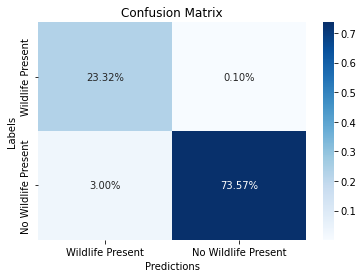

Accuracy: 0.968968968968969
Precision: 0.8859315589353612
Recall: 0.9957264957264957
F-Score: 0.9376257545271629


In [16]:
train_and_test_VGG11(training_loader, testing_loader, device, num_classes)


Training and Testing VGG19
epoch: 0
training loss: 0.03537650562433317 and training accuracy: 0.8875166889185581
testing loss: 0.011657203965539764 and testing accuracy: 0.94994994994995
epoch: 1
training loss: 0.014209251933715519 and training accuracy: 0.9432576769025367
testing loss: 0.009852678278806965 and testing accuracy: 0.954954954954955
epoch: 2
training loss: 0.010624862428108494 and training accuracy: 0.9546061415220294
testing loss: 0.009259874431686863 and testing accuracy: 0.9619619619619619
epoch: 3
training loss: 0.007643159969543637 and training accuracy: 0.9666221628838452
testing loss: 0.006308278945947972 and testing accuracy: 0.974974974974975
epoch: 4
training loss: 0.006080590666200482 and training accuracy: 0.9739652870493992
testing loss: 0.005463505374940873 and testing accuracy: 0.975975975975976


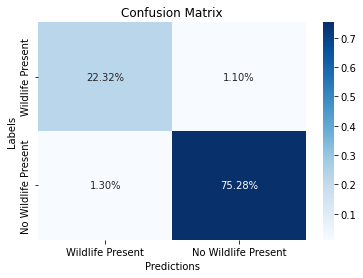

Accuracy: 0.975975975975976
Precision: 0.9449152542372882
Recall: 0.9529914529914529
F-Score: 0.948936170212766


In [17]:
train_and_test_VGG19(training_loader, testing_loader, device, num_classes)


Training and Testing ResNet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
training loss: 0.06061051254103505 and training accuracy: 0.880173564753004
testing loss: 0.01166746641385245 and testing accuracy: 0.960960960960961
epoch: 1
training loss: 0.011556052045153083 and training accuracy: 0.9542723631508678
testing loss: 0.007846855076013116 and testing accuracy: 0.9719719719719719
epoch: 2
training loss: 0.008058750152930453 and training accuracy: 0.9669559412550067
testing loss: 0.006360442603698692 and testing accuracy: 0.978978978978979
epoch: 3
training loss: 0.00655541277925132 and training accuracy: 0.9729639519359146
testing loss: 0.004771050392977289 and testing accuracy: 0.97997997997998
epoch: 4
training loss: 0.004430128479006828 and training accuracy: 0.9836448598130841
testing loss: 0.006788152395232531 and testing accuracy: 0.970970970970971


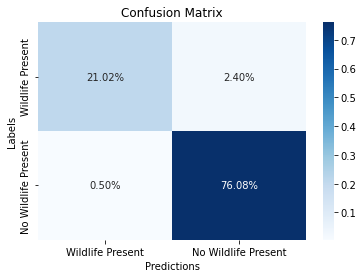

Accuracy: 0.970970970970971
Precision: 0.9767441860465116
Recall: 0.8974358974358975
F-Score: 0.9354120267260579


In [18]:
train_and_test_ResNet50(training_loader, testing_loader, device, num_classes)


Training and Testing ResNet152


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

epoch: 0
training loss: 0.05516037109024445 and training accuracy: 0.8818424566088118
testing loss: 0.010925011165478305 and testing accuracy: 0.9619619619619619
epoch: 1
training loss: 0.009778491164637216 and training accuracy: 0.9646194926568759
testing loss: 0.008639181893481104 and testing accuracy: 0.970970970970971
epoch: 2
training loss: 0.006588328579762138 and training accuracy: 0.972630173564753
testing loss: 0.008782985743724398 and testing accuracy: 0.965965965965966
epoch: 3
training loss: 0.004724779589899327 and training accuracy: 0.9833110814419226
testing loss: 0.005494484502472099 and testing accuracy: 0.97997997997998
epoch: 4
training loss: 0.003442887537579972 and training accuracy: 0.9886515353805073
testing loss: 0.005015072427384483 and testing accuracy: 0.9819819819819819


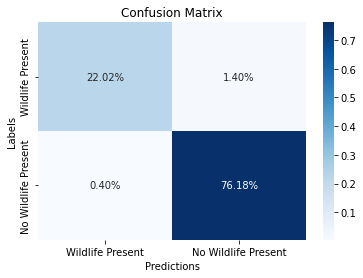

Accuracy: 0.9819819819819819
Precision: 0.9821428571428571
Recall: 0.9401709401709402
F-Score: 0.9606986899563319


In [19]:
train_and_test_ResNet152(training_loader, testing_loader, device, num_classes)


Training and Testing AlexNet


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

epoch: 0
training loss: 0.040804907547910566 and training accuracy: 0.8795060080106809
testing loss: 0.014882169478387386 and testing accuracy: 0.9459459459459459
epoch: 1
training loss: 0.01824521536375654 and training accuracy: 0.9292389853137517
testing loss: 0.013601036209487697 and testing accuracy: 0.9459459459459459
epoch: 2
training loss: 0.015591565550137127 and training accuracy: 0.9462616822429907
testing loss: 0.010835658997069817 and testing accuracy: 0.9529529529529529
epoch: 3
training loss: 0.013733471273108092 and training accuracy: 0.9462616822429907
testing loss: 0.010705397571719068 and testing accuracy: 0.958958958958959
epoch: 4
training loss: 0.012597717041880944 and training accuracy: 0.9522696929238985
testing loss: 0.010301947363859016 and testing accuracy: 0.958958958958959


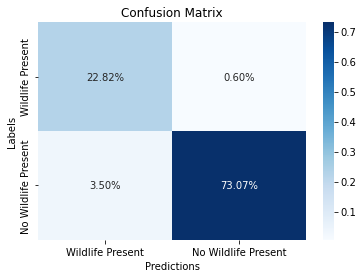

Accuracy: 0.958958958958959
Precision: 0.8669201520912547
Recall: 0.9743589743589743
F-Score: 0.9175050301810864


In [20]:
train_and_test_AlexNet(training_loader, testing_loader, device, num_classes)

In [21]:
#TODO: Get these working
#train_and_test_Faster_RCNN(training_loader, testing_loader, device, num_classes)
#train_and_test_YOLO(training_loader, testing_loader, device, num_classes)
#train_and_test_SSD(training_loader, testing_loader, device, num_classes)
#train_and_test_ViT(training_loader, testing_loader, device, num_classes)